### DataSet : Amazon Fine Food Reviews 

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q]How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.
<br>

* The dataset is available in two forms
   1. csv file
   2.SQLite Database
    
* We can use any one of the form to load data


#### Apply KNN algorithm to predit whether given new review is postive or negative

In [3]:
# importing required modules for data pre-processing, data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load data 
initial_data = pd.read_csv('Reviews.csv')
print("Shape of Data:\t",initial_data.shape)  # print dimensions of data 
initial_data['Score'].value_counts()

Shape of Data:	 (568454, 10)


5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [5]:
# Filter out data points which Score equal to 3 because they are neither +ve or -ve
initial_data = initial_data[initial_data['Score'] != 3]
print("Shape of Data after filtering which has score equal to 3: ",initial_data.shape)  # print dimensions of data 

# convert type of Score features to string 1) if 1<=Score<= 2 then 'negative' 2) if 4<=Score<=5 then 'positive'
def convert(value):
    if value >= 4:
        return 1
    return 0

actual_data = initial_data.Score
converted_data = actual_data.map(convert)
initial_data['Score'] = converted_data

initial_data.shape

Shape of Data after filtering which has score equal to 3:  (525814, 10)


(525814, 10)

##### Data Cleaning: Deduplication

We need remove if there are any duplicate entries in order to get unbiased results for the analysis of the data.

In [6]:
# Sorting data according to ProductId in ascending order
sorted_data=initial_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Deduplication of entries
staging_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(staging_data.shape)

staging_data=staging_data[staging_data.HelpfulnessNumerator<=staging_data.HelpfulnessDenominator]
print(staging_data.shape)

# How many positive and negative reviews are present in our dataset?
staging_data['Score'].value_counts()

(364173, 10)
(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

We have 0.5 million data points after removing duplicates.
So I am sampling data points so that I have data less than the original data

###### Following is the line for sample available in pandas:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html

######  Follwing is the constructor of sample:
DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)
- frac parameter tells about what fraction of data must return, valid values lies between [0,1]

In [7]:
print("Shape of data before sampling: ",staging_data.shape)   # count before sample

# select some random sample points
sample_data = staging_data.sample(frac = 0.009, random_state=0)

# print("Type of sampled data: ",type(sample_data))

print("Shape of sample data: ",sample_data.shape)

# Number of positive and negative points in sampled data 1 indicates +ve and 0 indicates -ve 
count = sample_data['Score'].value_counts()
print(count)

Shape of data before sampling:  (364171, 10)
Shape of sample data:  (3278, 10)
1    2791
0     487
Name: Score, dtype: int64


#### Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# import required modules
import re                # regular expression module used for pattern matching 
import string
import nltk             # natural language processing tool kit for text processing
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) # set of stopwords
sno = nltk.stem.SnowballStemmer('english') # initialising the snowball stemmer

# function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

# function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

# Code for implementing step-by-step the checks mentioned in the pre-processing phase
str1=' '
preprocessed_string=[]
for sent in sample_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)    # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) # final string of cleaned words
    preprocessed_string.append(str1)

In [13]:
# Adding a column of CleanedText which displays the data after pre-processing of the review 
sample_data['CleanedText'] = preprocessed_string 

print(sample_data.shape)

# To verify first few rows
sample_data[['Text','CleanedText']].head(5)

(3278, 11)


,Text,CleanedText
84633,I've known about my celiac disease for over 25...,b'ive known celiac diseas year tri mani brand ...
387497,The lollipops came quickly and added a great p...,b'lollipop came quick ad great pop color babi ...
275998,"This flavor rocks, as a Blueberry flavor lover...",b'flavor rock blueberri flavor lover product e...
29821,This tea is so wonderfully refreshing. It's l...,b'tea wonder refresh like comfort food best iv...
186462,This mix from Pamela's Products has been the t...,b'mix pamela product best far make soft delect...


In [14]:
# This is a time series dataset , so we need to train the model on past data and test it on lastest data

# Sorting data using time 
sample_data.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')


###### Machine Learning is all about math. For any Machine Learning model to work, we have to convert features which is having text to something(Vector) that an algorithm can use.

* There are lot of methods available to convert to text to vector. 
        1) Bag of words
        2) TF-IDF (term frequency–inverse document frequency)
        3) Avg W2V
        4) TFIDF-W2V
        
        

##### Bag of words approach :

We have class called CountVectorizer in scikit. Following is the syntax of constructor

class sklearn.feature_extraction.text.CountVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), analyzer=’word’, max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=class ‘numpy.int64’ )

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [33]:
# Vectorizing the features using Bag of words

from sklearn.feature_extraction.text import CountVectorizer

countVec_model = CountVectorizer(stop_words='english')
vectors = countVec_model.fit_transform(sample_data['CleanedText'].values)


print("Type of vectors: ",type(vectors))
print("Shape of bag of words : ",vectors.get_shape())

features = countVec_model.get_feature_names()
print("\n",features[:20]) # get first 20 features


labels = sample_data['Score']
dataset = vectors   # Actual data

Type of vectors:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of bag of words :  (3278, 7993)

 ['aaah', 'abil', 'abl', 'abound', 'abreast', 'abroad', 'absolut', 'absorb', 'absorpt', 'absurd', 'abund', 'abus', 'academi', 'acai', 'accel', 'accent', 'accept', 'access', 'accid', 'accident']


In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation


In [18]:
# Split data in train and test data set 

X_train,X_test,y_train,y_test = cross_validation.train_test_split(dataset,labels, test_size=0.2, random_state=0)


print("Shape of dataset and lables : ",(dataset.shape,labels.shape))

print("Shape of X_train and y_train:  ",(X_train.shape,y_train.shape))

print("Shape of X_test and y_test:  ",(X_test.shape,y_test.shape))

print("Type of X_train and y_train : ",(type(X_train),type(y_train)))

X_train_dense = X_train.todense()
X_test_dense = X_test.todense()

Shape of dataset and lables :  ((3278, 7993), (3278,))
Shape of X_train and y_train:   ((2622, 7993), (2622,))
Shape of X_test and y_test:   ((656, 7993), (656,))
Type of X_train and y_train :  (<class 'scipy.sparse.csr.csr_matrix'>, <class 'pandas.core.series.Series'>)


#### KNN using brute force method

In [19]:
# 10 fold cross validation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)

print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 17
The misclassification error for each k value is :  [0.181 0.156 0.152 0.149 0.15  0.151 0.151 0.15  0.149 0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
 0.15 ]


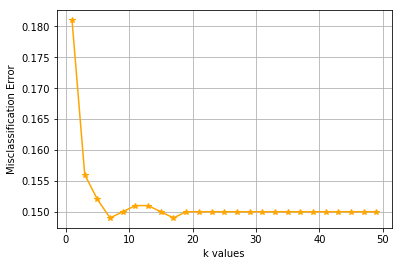

In [34]:
plt.plot(neighbors,MSE,marker="*",color="orange")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [22]:
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 85.823171 percent


#### KNN using kd tree approach

In [25]:
# 10 fold cross validation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
    scores = cross_val_score(knn, X_train.todense(), y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)

print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 17
The misclassification error for each k value is :  [0.185 0.159 0.154 0.15  0.15  0.151 0.151 0.149 0.148 0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
 0.15 ]


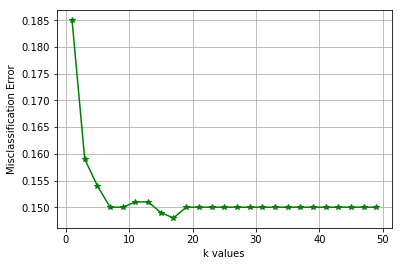

In [38]:
plt.plot(neighbors,MSE,marker="*",color="green")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [27]:
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(X_train.todense(), y_train)

# predict the response
pred = knn_optimal.predict(X_test.todense())

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 85.823171 percent


##### Observations:
* KNN using Bag of Words Feature Extraction has accuracy of 85.82% with hyper parameter or optimal k = 17.
* Brute Force method took more time than the KD Tree approach while predicting the test data points.

#### TF-IDF (term frequency–inverse document frequency):

In [17]:
# import required modules
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vectors_tf_idf = tf_idf_vect.fit_transform(sample_data['Text'].values)

print("Type of vectors: ",type(vectors_tf_idf))
print("Shape : ",vectors_tf_idf.get_shape())

features = tf_idf_vect.get_feature_names()
print("\n",features[:20]) # get first 20 features


labels = sample_data['Score']
dataset = vectors_tf_idf   # Actual data



Type of vectors:  <class 'scipy.sparse.csr.csr_matrix'>
Shape :  (3278, 120954)

 ['00', '00 am', '00 and', '00 at', '00 bag', '00 box', '00 br', '00 for', '00 here', '00 how', '00 item', '00 on', '00 or', '00 pass', '00 per', '00 that', '00 they', '00 this', '00 tin', '00 to']


In [38]:
# split data into train and test data set

X_train,X_test,y_train,y_test = cross_validation.train_test_split(dataset,labels,test_size = 0.3,random_state = 0)

print("Shape of dataset and lables : ",(dataset.shape,labels.shape))

print("Shape of X_train and y_train:  ",(X_train.shape,y_train.shape))

print("Shape of X_test and y_test:  ",(X_test.shape,y_test.shape))

print("Type of X_train and y_train : ",(type(X_train),type(y_train)))


Shape of dataset and lables :  ((3278, 88628), (3278,))
Shape of X_train and y_train:   ((2294, 88628), (2294,))
Shape of X_test and y_test:   ((984, 88628), (984,))
Type of X_train and y_train :  (<class 'scipy.sparse.csr.csr_matrix'>, <class 'pandas.core.series.Series'>)


In [39]:
# 10 fold cross vaalidation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)


print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 11
The misclassification error for each k value is :  [0.21  0.162 0.15  0.149 0.147 0.144 0.146 0.146 0.147 0.147 0.148 0.149
 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.15  0.15  0.15  0.15
 0.15 ]


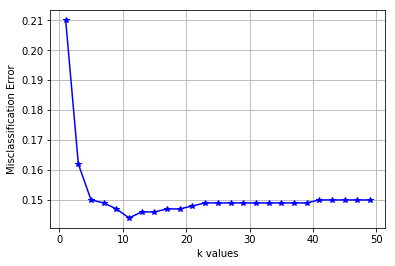

In [39]:
plt.plot(neighbors,MSE,marker="*",color="blue")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [40]:
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 86.382114 percent


#### KD Tree Approach:

In [41]:
# 10 fold cross validation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
    scores = cross_val_score(knn, X_train.todense(), y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)

print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 11
The misclassification error for each k value is :  [0.21  0.162 0.15  0.149 0.147 0.144 0.146 0.146 0.147 0.147 0.148 0.149
 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.15  0.15  0.15  0.15
 0.15 ]


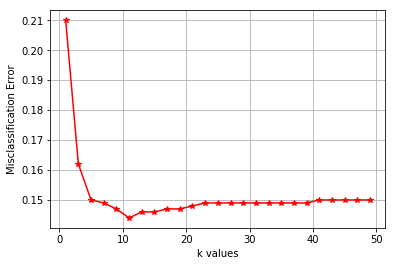

In [41]:
plt.plot(neighbors,MSE,marker="*",color="red")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [43]:
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(X_train.todense(), y_train)

# predict the response
pred = knn_optimal.predict(X_test.todense())

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 86.382114 percent


##### Observations:
* KNN using TF-IDF Feature Extraction has accuracy of 86.38% with hyper parameter or optimal k = 11.
* Brute Force method took more time than the KD Tree approach while predicting the test data points.

#### Feature Extraction : AvgW2vec

In [19]:
i=0
list_of_sent=[]
for sent in sample_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

print(sample_data['Text'].values[1])
print("------------------------------------------------------------------------------------")
print(list_of_sent[1])



I'm never dissapointed with the great gadgets this company comes out with. My brother picked up the new Concerto for me and it is absolutely awesome! My wife likes whites and I like reds, so the 2 stoppers really come in handy. Also, I love the new clicking sound it makes when the vacuum is at the correct level. Neat design, great looking gift, the absolute best invention for saving wines.
------------------------------------------------------------------------------------
['im', 'never', 'dissapointed', 'with', 'the', 'great', 'gadgets', 'this', 'company', 'comes', 'out', 'with', 'my', 'brother', 'picked', 'up', 'the', 'new', 'concerto', 'for', 'me', 'and', 'it', 'is', 'absolutely', 'awesome', 'my', 'wife', 'likes', 'whites', 'and', 'i', 'like', 'reds', 'so', 'the', 'stoppers', 'really', 'come', 'in', 'handy', 'also', 'i', 'love', 'the', 'new', 'clicking', 'sound', 'it', 'makes', 'when', 'the', 'vacuum', 'is', 'at', 'the', 'correct', 'level', 'neat', 'design', 'great', 'looking', 'gif

#### Feature Extraction using Avg Word2vec

Syntax:
class gensim.models.word2vec.Word2Vec(sentences=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=())

Here size indicates number of features we want

In [21]:
# Train your own Word2Vec model using your own text corpus
import gensim

w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=4) 

w2v_model.wv.most_similar('tasty')

[('pretty', 0.9945555925369263),
 ('well', 0.9942581653594971),
 ('smooth', 0.990772008895874),
 ('strong', 0.9906314611434937),
 ('nutty', 0.9899477958679199),
 ('overpowering', 0.9881852865219116),
 ('salty', 0.9880739450454712),
 ('texture', 0.9879239797592163),
 ('delicious', 0.987364649772644),
 ('rich', 0.9865464568138123)]

In [13]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))
print(sent_vectors[0])



[ 5.25625128e-02 -8.14693503e-02  6.06883931e-02  8.26836290e-02
  7.17291796e-02 -1.82958794e-01 -7.08297589e-02  1.49056045e-01
  6.95279131e-02 -1.08957866e-01  9.31790814e-02 -5.25769086e-02
  1.92632052e-01  4.71215247e-02 -1.17906090e-01  1.00446533e-01
  1.92376492e-01  1.10568363e-02 -1.15295123e-01 -5.75953993e-02
  2.89442555e-02 -8.81179823e-02  1.62205057e-01  2.11159865e-02
  8.89449816e-02 -1.82774960e-01 -1.18032523e-01 -2.70026444e-01
  6.96176336e-02  1.56161765e-01 -8.41796388e-02  2.23614261e-02
 -9.35770414e-02 -2.11037657e-02  2.27613540e-01  2.31516144e-01
 -2.24751606e-02 -4.57658012e-02  6.41875734e-02 -1.48674728e-01
  1.06650934e-01 -9.65585656e-03  5.83298406e-02 -7.27818232e-02
  4.00497114e-02  4.29814116e-02  1.99675186e-01 -2.91854803e-01
  1.53772073e-01  2.39569463e-01  6.01733203e-03 -1.68024315e-01
 -6.27241272e-02  9.68150295e-03 -6.53248814e-02  1.74050824e-01
  9.30717031e-02  2.08790401e-01 -1.69059560e-01  3.97508697e-02
  2.15151842e-02  3.82144

In [19]:
X = sent_vectors
y = sample_data['Score']

# split data into train and test data set

X_train_w2vec,X_test_w2vec,y_train_w2vec,y_test_w2vec = cross_validation.train_test_split(X,y,test_size = 0.3,random_state = 0)

print("Shape of X and y : ",(len(X),len(y)))

print("Shape of X_train_w2vec and y_train_w2vec:  ",(len(X_train_w2vec),y_train_w2vec.shape))

print("Shape of X_test_w2vec and y_test_w2vec:  ",(len(X_test_w2vec),y_test_w2vec.shape))

print("Type of X_train_w2vec and y_train_w2vec : ",(type(X_train_w2vec),type(y_train_w2vec)))

Shape of X and y :  (3278, 3278)
Shape of X_train_w2vec and y_train_w2vec:   (2294, (2294,))
Shape of X_test_w2vec and y_test_w2vec:   (984, (984,))
Type of X_train_w2vec and y_train_w2vec :  (<class 'list'>, <class 'pandas.core.series.Series'>)


#### KNN using brute force method : Avg W2vec

In [20]:
# 10 fold cross vaalidation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'brute')
    scores = cross_val_score(knn, X_train_w2vec, y_train_w2vec, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)


print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 21
The misclassification error for each k value is :  [0.25  0.195 0.167 0.161 0.158 0.153 0.152 0.151 0.151 0.151 0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
 0.15 ]


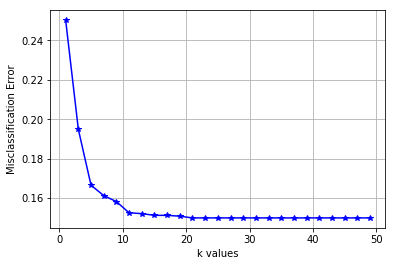

In [21]:
plt.plot(neighbors,MSE,marker="*",color="blue")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [23]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')

# fitting the model
knn_optimal.fit(X_train_w2vec, y_train_w2vec)

# predict the response
pred = knn_optimal.predict(X_test_w2vec)

# evaluate accuracy
acc = accuracy_score(y_test_w2vec, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 21 is 85.365854 percent


#### KNN using kd tree approach : AvgWord2Vec

In [27]:
# 10 fold cross validation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
    scores = cross_val_score(knn, X_train_w2vec, y_train_w2vec, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)

print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 21
The misclassification error for each k value is :  [0.25  0.195 0.167 0.161 0.158 0.153 0.152 0.151 0.151 0.151 0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
 0.15 ]


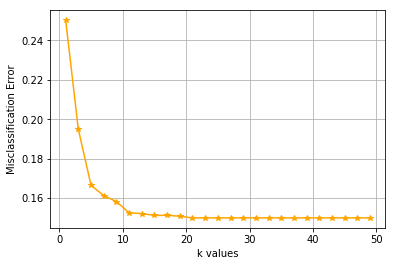

In [28]:
plt.plot(neighbors,MSE,marker="*",color="orange")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [29]:
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(X_train_w2vec, y_train_w2vec)

# predict the response
pred2_w2vec = knn_optimal.predict(X_test_w2vec)

# evaluate accuracy
acc = accuracy_score(y_test_w2vec, pred2_w2vec) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 21 is 85.365854 percent


##### Observations:
* KNN using Avg W2Vec Feature Extraction has accuracy of 85.36% with hyper parameter or optimal k = 21.
* Brute Force method took more time than the KD Tree approach while predicting the test data points.

#### Feature Extraction : TF-IDF weighted Word2Vec

In [22]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sample_data['Text'].values)

In [23]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# vectors_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [24]:
X = tfidf_sent_vectors
y = sample_data['Score']

# split data into train and test data set

X_train_tfidfw2vec,X_test_tfidfw2vec,y_train_tfidfw2vec,y_test_tfidfw2vec = cross_validation.train_test_split(X,y,test_size = 0.3,random_state = 0)

print("Shape of X and y : ",(len(X),len(y)))

print("Shape of X_train_tfidfw2vec and y_train_tfidfw2vec:  ",(len(X_train_tfidfw2vec),y_train_tfidfw2vec.shape))

print("Shape of X_test_tfidfw2vec and y_test_tfidfw2vec:  ",(len(X_test_tfidfw2vec),y_test_tfidfw2vec.shape))

print("Type of X_train_tfidfw2vec and y_train_tfidfw2vec : ",(type(X_train_tfidfw2vec),type(y_train_tfidfw2vec)))

Shape of X and y :  (3278, 3278)
Shape of X_train_tfidfw2vec and y_train_tfidfw2vec:   (2294, (2294,))
Shape of X_test_tfidfw2vec and y_test_tfidfw2vec:   (984, (984,))
Type of X_train_tfidfw2vec and y_train_tfidfw2vec :  (<class 'list'>, <class 'pandas.core.series.Series'>)


#### KNN using brute force method: TF-IDF weighted Word2Vec

In [25]:
# 10 fold cross vaalidation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'brute')
    scores = cross_val_score(knn,X_train_tfidfw2vec,y_train_tfidfw2vec, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)


print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 19
The misclassification error for each k value is :  [0.258 0.193 0.17  0.16  0.155 0.154 0.152 0.151 0.151 0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
 0.15 ]


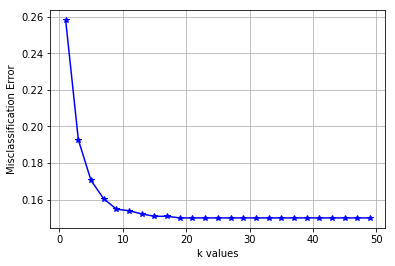

In [26]:
plt.plot(neighbors,MSE,marker="*",color="blue")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [27]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')

# fitting the model
knn_optimal.fit(X_train_tfidfw2vec,y_train_tfidfw2vec)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2vec)

# evaluate accuracy
acc = accuracy_score(y_test_tfidfw2vec, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 19 is 85.467480 percent


#### KNN using kd tree approach : TF-IDF weighted Word2Vec

In [28]:
# 10 fold cross validation for finding optimal k 

# creating odd list of K for KNN
neighbors = [ x for x in range(0,50) if x % 2 != 0 ]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
    scores = cross_val_score(knn,X_train_tfidfw2vec,y_train_tfidfw2vec, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is : %d' % optimal_k)

print("The misclassification error for each k value is : ", np.round(MSE,3))


The optimal number of neighbors is : 19
The misclassification error for each k value is :  [0.258 0.193 0.17  0.16  0.155 0.154 0.152 0.151 0.151 0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
 0.15 ]


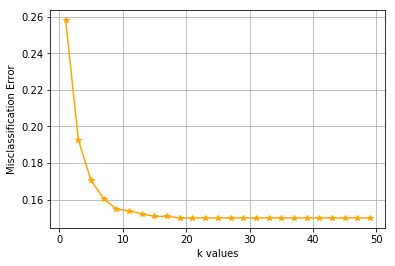

In [29]:
plt.plot(neighbors,MSE,marker="*",color="orange")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("k values")
plt.grid()
plt.show()

In [30]:
knn_optimal = KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(X_train_tfidfw2vec,y_train_tfidfw2vec)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2vec)

# evaluate accuracy
acc = accuracy_score(y_test_tfidfw2vec, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f percent' % (optimal_k, acc))


The accuracy of the knn classifier for k = 19 is 85.467480 percent


##### Observations:
* KNN using TF-IDF weighted Word2Vec Feature Extraction has accuracy of 85.46% with hyper parameter or optimal k = 19.
* Brute Force method took more time than the KD Tree approach while predicting the test data points.

#### Conclusion:
    1) Using Bag of Words , It has error rate of 14.17% with k = 17
    2) Using TF-IDF (term frequency–inverse document frequency), It has error rate of 13.61% with k = 11
    3) Using Average w2vec, It has error rate of 14.63% with k = 21.
    4) Using TF-IDF weighted Word2Vec Feature Extraction, It has error rate of 14.54% with k = 19